In [1]:
from spynnaker_external_devices_plugin.pyNN.connections\
    .spynnaker_live_spikes_connection import SpynnakerLiveSpikesConnection

In [2]:
# plotter in python
%matplotlib notebook
import matplotlib.pyplot as plt

import time as my_time
import numpy

In [13]:
feedback_delay = 20/1000.

n_neurons = 3000

In [3]:
# SpynnakerLiveSpikesConnection(self, receive_labels=None, send_labels=None, local_host=None, local_port=19999)

# Set up the live connection for sending and receiving spikes
live_spikes_connection = SpynnakerLiveSpikesConnection(
    receive_labels=["LSM_EXC","LSM_INH"], 
    send_labels=["spike_injector"],
    local_port=12346)

In [4]:
# Create an initialisation method
def init_pop(label, n_neurons, run_time_ms, machine_timestep_ms):
    print "{} has {} neurons".format(label, n_neurons)
    print "Simulation will run for {}ms at {}ms timesteps".format(run_time_ms, machine_timestep_ms)

In [11]:
received_spikes = {'LSM_EXC':[],'LSM_INH':[]}
def receive_spikes(label, time, neuron_ids):
    received_spikes[label].append([time,neuron_ids])
#     my_time.sleep(feedback_delay)
#     live_spikes_connection.send_spikes("spike_injector", neuron_ids)
#     for neuron_id in neuron_ids:
#         print "Received spike at time", time, "from", label, "-", neuron_id

In [14]:
initial_array = numpy.arange(n_neurons)
numpy.random.shuffle(initial_array)
def started(label, sender):
    print "{}=>Simulation has started!".format(label)
    sender.send_spikes("spike_injector", initial_array[:100])

In [15]:
live_spikes_connection.add_receive_callback("LSM_EXC", receive_spikes)
live_spikes_connection.add_receive_callback("LSM_INH", receive_spikes)

live_spikes_connection.add_init_callback("LSM_EXC", init_pop)
live_spikes_connection.add_init_callback("LSM_INH", init_pop)
live_spikes_connection.add_init_callback("spike_injector", init_pop)

live_spikes_connection.add_start_callback("spike_injector",started)

spike_injector has 3000 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
LSM_EXC has 2400 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
LSM_INH has 600 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
spike_injector=>Simulation has started!


spynnaker database connection for None:12346: <Thread(start callback thread for live_event_connection12346:0.0.0.0, initial daemon)>.start(): starting thread
start callback thread for live_event_connection12346:0.0.0.0: <Thread(start callback thread for live_event_connection12346:0.0.0.0, started daemon 4616241152)>.__bootstrap(): thread started
start callback thread for live_event_connection12346:0.0.0.0: <Thread(start callback thread for live_event_connection12346:0.0.0.0, started daemon 4616241152)>.__bootstrap(): normal return


In [22]:
times=[]
spikes=[]
times+=[j for i in received_spikes['LSM_EXC'] for j in [i[0]]*len(i[1])]
spikes+=[j for i in received_spikes['LSM_EXC'] for j in i[1]]

times+=[j for i in received_spikes['LSM_INH'] for j in [i[0]]*len(i[1])]
spikes+=[j for i in received_spikes['LSM_INH'] for j in i[1]]

<IPython.core.display.Javascript object>


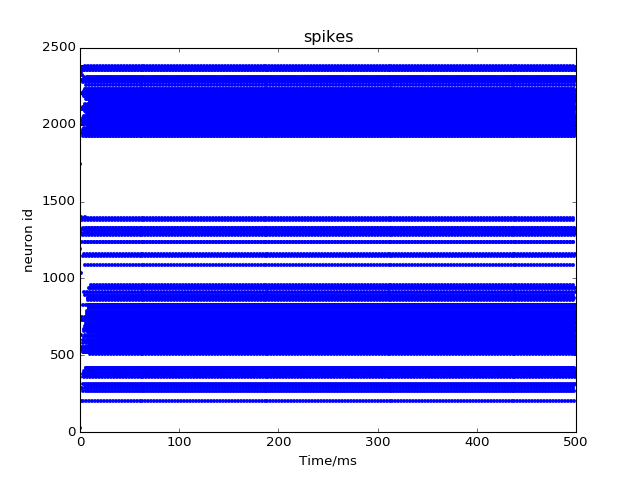

In [23]:
plt.figure()
plt.plot(times,spikes,'.')
plt.ylabel('neuron id')
plt.xlabel('Time/ms')
plt.title('spikes')
plt.show()